In [ ]:
## mount drive as the data is stored in it.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import sys
import glob
import re
# Flask utils
from flask import Flask,flash, request, render_template,send_from_directory
from werkzeug.utils import secure_filename
import pathlib, shutil
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import skimage
import cv2
from google.colab.patches import cv2_imshow
from skimage import io,img_as_float
from skimage.exposure import histogram
from numpy import expand_dims
from tensorflow.keras.utils import img_to_array,load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L1, L2, L1L2
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl

In [ ]:
train_image_path = '/content/drive/My Drive/pharmaceutical_drug/train'
test_image_path = '/content/drive/My Drive/pharmaceutical_drug/test'

In [ ]:
train = pd.read_csv('/content/drive/My Drive/pharmaceutical_drug/Training_set.csv')
test = pd.read_csv('/content/drive/My Drive/pharmaceutical_drug/Testing_set.csv')
train.head()

filename     label
0  Image_1.jpg    Bioflu
1  Image_2.jpg  Bactidol
2  Image_3.jpg  Fish Oil
3  Image_4.jpg  Fish Oil
4  Image_5.jpg    Bioflu

In [31]:
def switch(t):
     if t=='Bioflu':
         u='Used for: Fungal Infections (Cough,Cold,Body pain etc.)'
         s='Side Effects: Headache, Nausea, Stomach'
         d='Dosage: Adult & children>12 1 tab every 6 hr'
     elif t=='Bactidol':
          u='Used for:Mouth and Throat Infections'
          s='Side Effects: Allergic contact dermatitis, taste & smell alterations'
          d='Dosage: Rinse mouth or gargle w/ at least 15 mL for 45 sec bd-tds'
     elif t=='Fish Oil':
          u='Uses:Reduce the risk of CV diseases'
          s='Side Effects:Nauseas, Loose Stools, Stomach Upset'
          d='Dosage:6 gms daily by mouth for up to 12 weeks'
     elif t=='Alaxan':
          u='Uses:Muscle pains, Fever'
          s='Side Effects:GI effects, Renal effects, Hepatic effects, Dermatologic effects'
          d='Dosage: 1 cap every 6 hours'
     elif t=='Neozep':
          u='Uses:Clogged and running nose, fever, body aches, headache, sinus'
          s='Side Effects:Nausea, diarrhea, skin rashes, chest tightedness, insomina'
          d='Dosage:By mouth for every 6 to 8 hours'
     elif t=='Biogesic':
          u='Uses: Pain Relief'
          s='Side Effects: Nausea, Vomiting, Diarrhea, Dizziness, Abdominal pain, Headache, Insomnia, Decreased Appetite'
          d='Dosage: Adults and Children >12 years: 1-2 tabs every 4-6 hrs, Dont take >8 tabs in 24hrs'
     elif t=='Kremil S':
          u='Uses:Hyperacidity'
          s='Side Effects:Constipation, Kidney impairment problems'
          d='Dosage:1 to 2 tabs to be taken one hour after each meal and at bedtime'
     elif t=='Decolgen':
          u='Uses:Common cold symptoms'
          s='Side Effects:Vomiting, Headache, Restlessness, Anxiety, Dizziness, Tremors, Pale skin, High blood pressure, Seizure, Cerebral hemorrhage'
          d='Dosage:Adults and Children >12 years: 1 tab every 6 hrs'
     elif t=='DayZinc':
          u='Uses:Vitamin C and Zinc deficiency'
          s='Side Effects:diarrhea, GI tract problems'
          d='Dosage:It varies with age, for adult 1 capsule daily'
     elif t=='Medicol':
          u='Uses','Different types of aches (head,tooth,muscular,back)'
          s='Side Effects','Stomach/Mouth ulcers,kidney problems, dizziness, drowsiness'
          d='Dosage','1 softgel capsule with a glassful of water every 4 to 6 hours as needed'
     return u,s,d


In [32]:
switch('Bioflu')

('Used for: Fungal Infections (Cough,Cold,Body pain etc.)',
 'Side Effects: Headache, Nausea, Stomach',
 'Dosage: Adult & children>12 1 tab every 6 hr')

In [ ]:
print(f'The train set has {train.shape[0]} images \n while the test set has {test.shape[0]} images')

The train set has 7000 images 
 while the test set has 3000 images


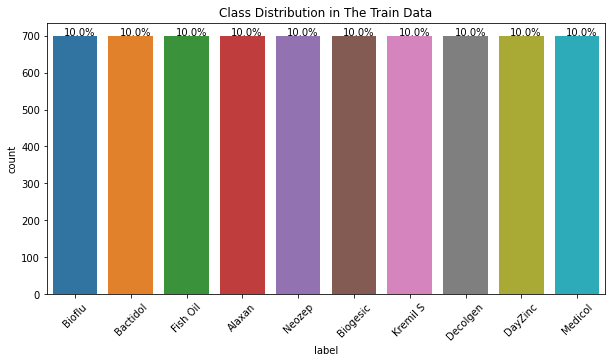

In [ ]:
## check the class distribution in the train dataset

plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'label', data = train)
size = len(train)
for p in ax.patches:
  height, width = p.get_height(), p.get_width()
  x, y = p.get_x(), p.get_y()
  percent = round(height/size * 100, 2)
  label = f'{percent}%'
  ax.annotate(label,(x + width/2- width/4, height))

plt.xticks(rotation=45)
plt.title('Class Distribution in The Train Data')
plt.show()

In [ ]:
path = '/content/drive/My Drive/pharmaceutical_drug/train'
def plot_images(df):
  images = list(df['filename'][:25])
  files = [os.path.join(path, img) for img in images]
  imgs = [Image.open(file) for file in files]

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(5*w, 5*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%5*w, i//5*h))
  return grid

def img_size(df):
  images = list(df['filename'][:5])
  files = [os.path.join(path, img) for img in images]
  imgs = [Image.open(file) for file in files]
  for i, img in enumerate(imgs):
     print(img.size)

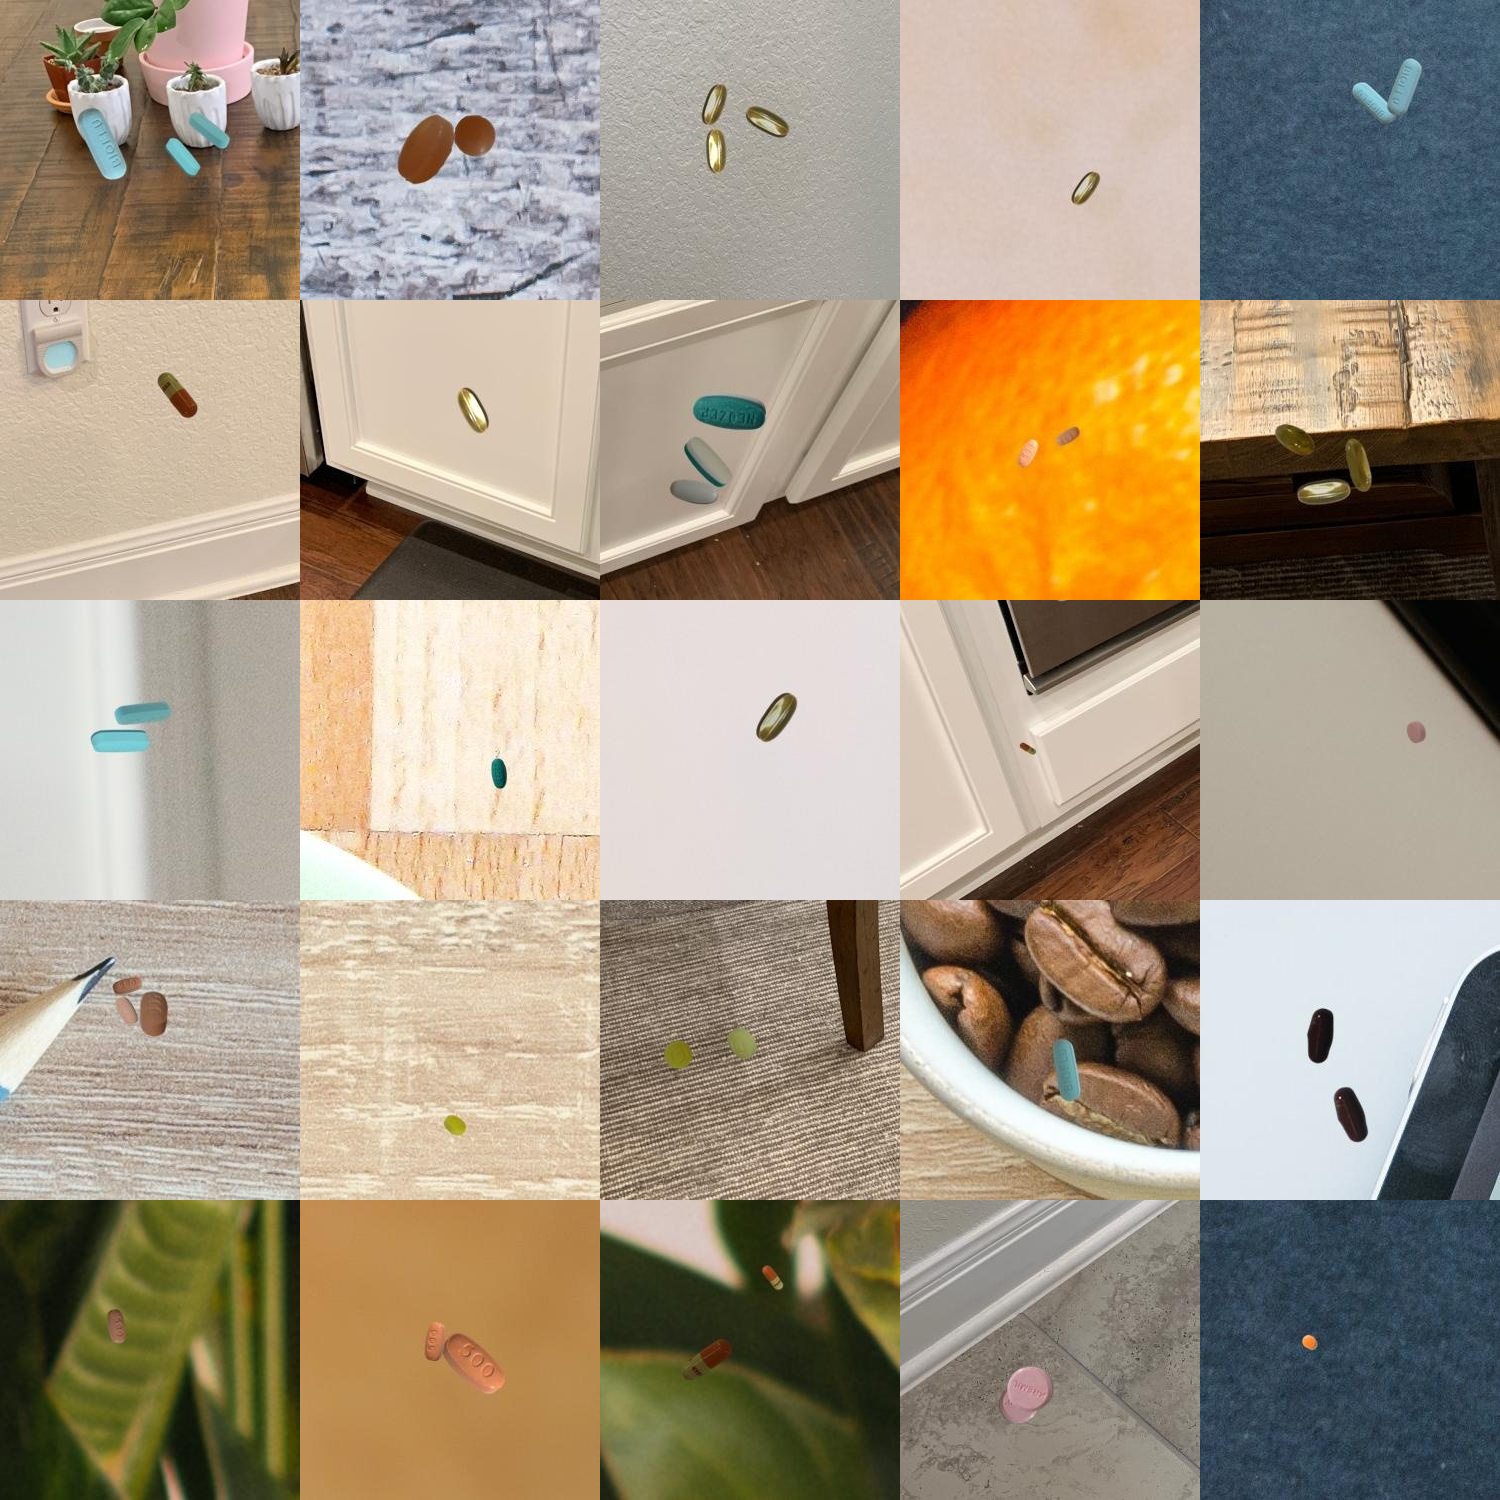

In [ ]:
plot_images(train)

## Edge Detection

### Sobel

In [ ]:
def sobel_CV2(image_name):
  im_location = image_name
  img = cv2.imread(im_location) 
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  sobelx64f = cv2.Sobel(gray_image,cv2.CV_64F,1,0,ksize=3)
  abs_sobel_x64f = np.absolute(sobelx64f)
  sobel_x_8u = np.uint8(abs_sobel_x64f)
  sobely64f = cv2.Sobel(gray_image,cv2.CV_64F,0,1,ksize=3)
  abs_sobel_y64f = np.absolute(sobely64f)
  sobel_y_8u = np.uint8(abs_sobel_y64f)
  magnitude = np.hypot(sobel_x_8u, sobel_y_8u)
  theta = np.arctan2(sobel_y_8u , sobel_x_8u) 
  return cv2_imshow(np.uint8(magnitude))

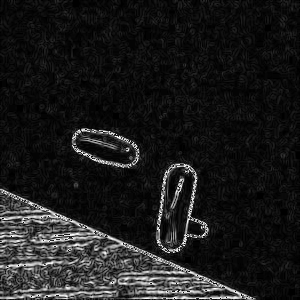

In [ ]:
sobel_CV2('/content/drive/My Drive/pharmaceutical_drug/train/Image_1096.jpg')

### Canny

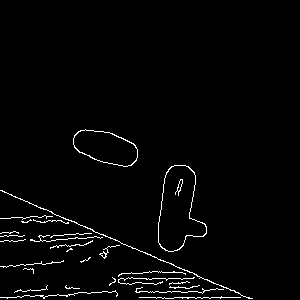

In [ ]:
def canny_CV2(image_name):
    im_location = image_name
    image = cv2.imread(im_location)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image,(3,3),cv2.BORDER_DEFAULT)
    edges = cv2.Canny(blurred_image.astype(np.uint8),100, 200)
    return cv2_imshow(np.uint8(edges))
canny_CV2('/content/drive/My Drive/pharmaceutical_drug/train/Image_1096.jpg')

## Masking

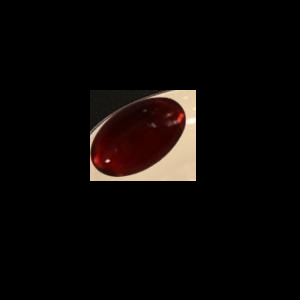

In [ ]:
def rectangular_masking(image_name):
  im_location = image_name
  image = cv2.imread(im_location)
  mask = np.zeros(image.shape[:2], dtype="uint8")
  cv2.rectangle(mask, (90, 90), (195, 180), 255, -1)
  masked = cv2.bitwise_and(image, image, mask=mask)
  cv2_imshow(masked)
  cv2.waitKey(0)
masking('/content/drive/My Drive/pharmaceutical_drug/train/Image_1097.jpg')

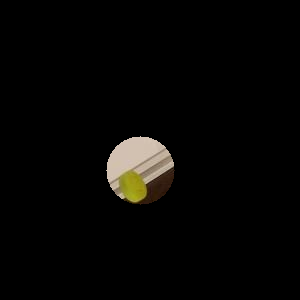

In [ ]:
def circular_masking(image_name):
  im_location = image_name
  image = cv2.imread(im_location)
  mask = np.zeros(image.shape[:2], dtype="uint8")
  cv2.circle(mask, (140, 170), 34, 255, -1)
  masked = cv2.bitwise_and(image, image, mask=mask)
  cv2_imshow(masked)
  cv2.waitKey(0)
circular_masking('/content/drive/My Drive/pharmaceutical_drug/train/Image_1098.jpg')

## Sample Image

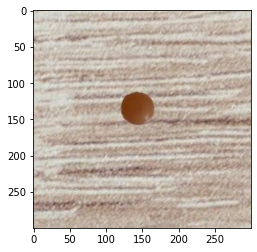

In [ ]:
image = io.imread('/content/drive/My Drive/pharmaceutical_drug/train/Image_1001.jpg')
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

## Three channels (RGB)

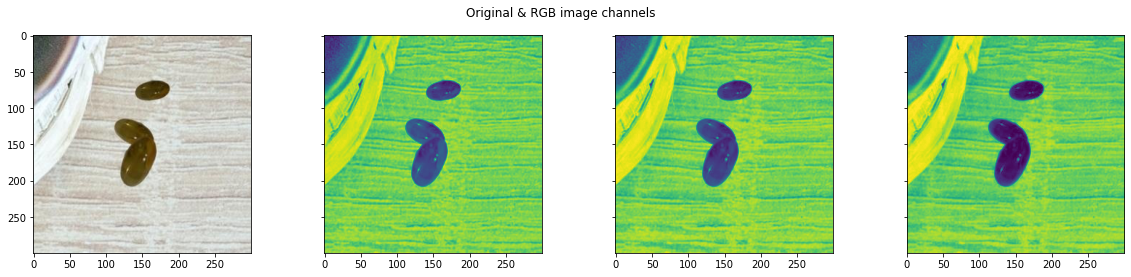

In [ ]:
def channels(image_name):
  image_rgb = io.imread(image_name)
  i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
  i.set_figwidth(20) 
  im1.imshow(image_rgb)  #Original image
  im2.imshow(image_rgb[:, : , 0]) #Red
  im3.imshow(image_rgb[:, : , 1]) #Green
  im4.imshow(image_rgb[:, : , 2]) #Blue
  i.suptitle('Original & RGB image channels')
channels('/content/drive/My Drive/pharmaceutical_drug/train/Image_1004.jpg')

## Grayscale image

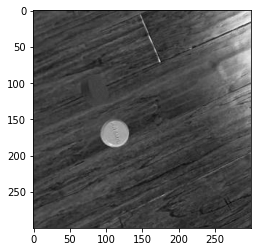

In [ ]:
def grayscale(image_name):
  image_gray = io.imread(image_name)
  gray_image = skimage.color.rgb2gray(image_gray)
  plt.imshow(gray_image, cmap = 'gray')
grayscale('/content/drive/My Drive/pharmaceutical_drug/train/Image_1010.jpg')

## Histogram of gray values

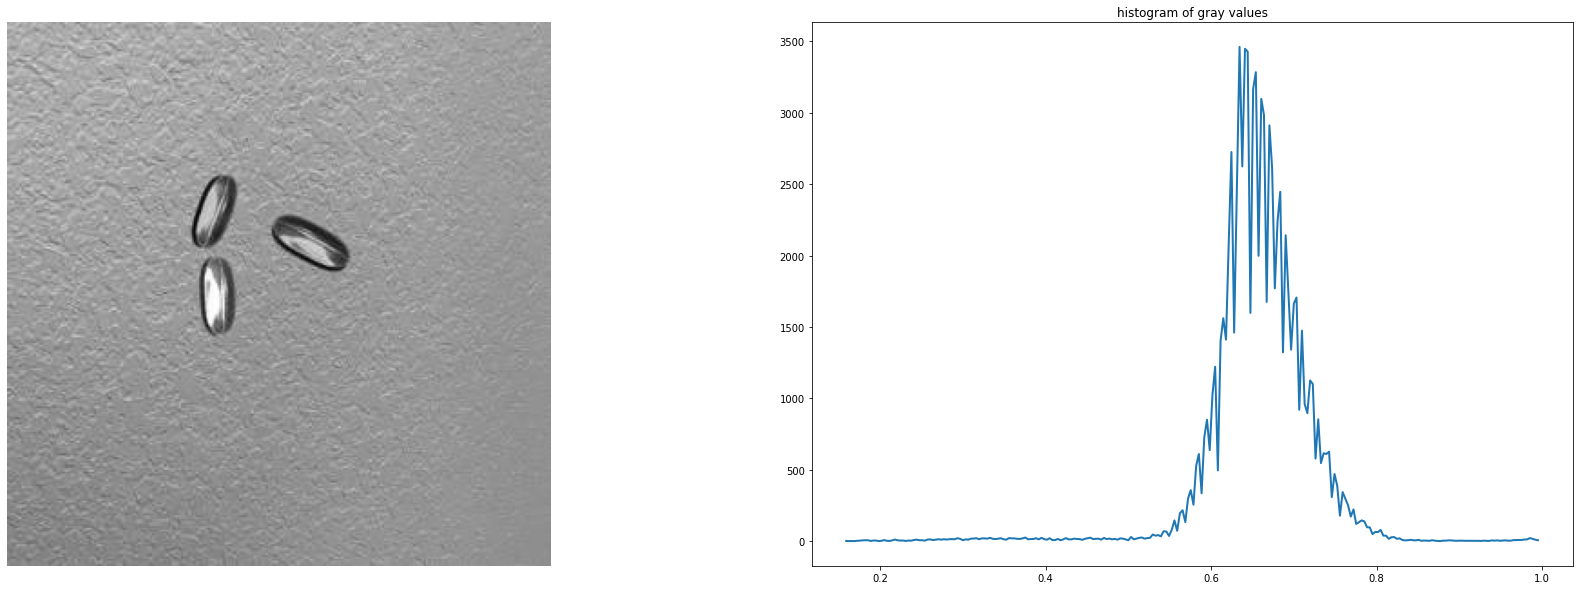

In [6]:
def hist(image_name):
   image = io.imread(image_name)
   image=img_as_float(image)
   gray_image = skimage.color.rgb2gray(image)
   hist, hist_centers = histogram(gray_image)
   fig, axes = plt.subplots(1, 2, figsize=(30, 10))
   axes[0].imshow(gray_image, cmap=plt.cm.gray)
   axes[0].axis('off')
   axes[1].plot(hist_centers, hist, lw=2)
   axes[1].set_title('histogram of gray values')
hist('Image_3.jpg')

## Normalized image

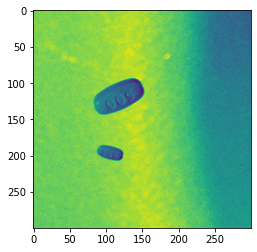

In [ ]:
def Normalization(image_name):
  image_normal = io.imread(image_name)
  gray_image = skimage.color.rgb2gray(image_normal)
  norm_image = (gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))
  plt.imshow(norm_image)
Normalization('/content/drive/My Drive/pharmaceutical_drug/train/Image_1013.jpg')

## Image shifting in three positions

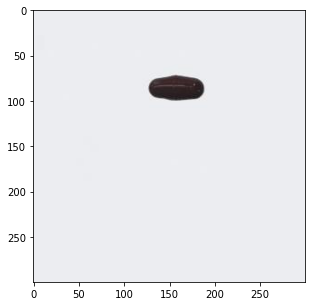

In [5]:
def shifting(image_name):
  image_shifting = io.imread(image_name)
  data = img_to_array(image_shifting)
  samples = expand_dims(image_shifting, 0)
  datagen = ImageDataGenerator(width_shift_range=[-50,100])
  it = datagen.flow(samples, batch_size=1)
  fig, im = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  image = next(it)[0].astype('uint8')
  im.imshow(image)
shifting('Image_196.jpg') 

## Image Flipping

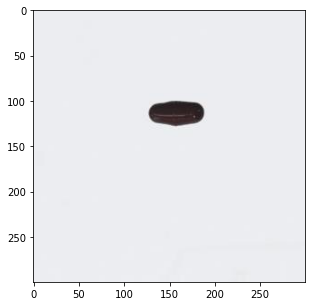

In [13]:
def Flipping(image_name):
  image_flipping = io.imread(image_name)
  data = img_to_array(image_flipping)
  samples = expand_dims(image_flipping, 0)
  datagen = ImageDataGenerator(horizontal_flip=False, vertical_flip=True)
  it = datagen.flow(samples, batch_size=1)
  fig, im = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  image = next(it)[0].astype('uint8')
  im.imshow(image)
Flipping('Image_196.jpg')

## Image Rotation

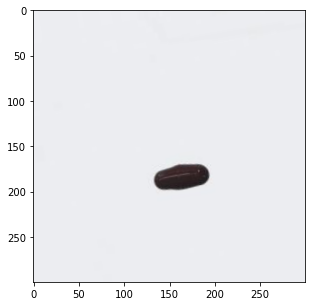

In [14]:
def Rotation(image_name):
  image_rotation = io.imread(image_name)
  data = img_to_array(image_rotation)
  samples = expand_dims(image_rotation, 0)
  datagen = ImageDataGenerator(rotation_range=20, fill_mode='nearest')
  it = datagen.flow(samples, batch_size=1)
  fig, im = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  image = next(it)[0].astype('uint8')
  im.imshow(image)
Rotation('Image_196.jpg')

## Changing Image brightness level

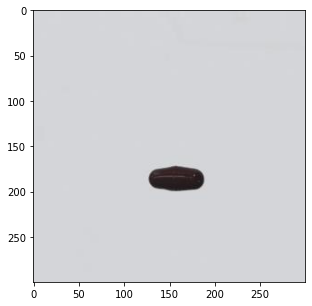

In [17]:
def brightness_level(image_name):
  image_brightness = io.imread(image_name)
  data = img_to_array(image_brightness)
  samples = expand_dims(image_brightness, 0)
  datagen = ImageDataGenerator(brightness_range=[0.5,2.0])
  it = datagen.flow(samples, batch_size=1)
  fig, im = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  image = next(it)[0].astype('uint8')
  im.imshow(image)
brightness_level('Image_196.jpg')

## Image Standardization 

/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


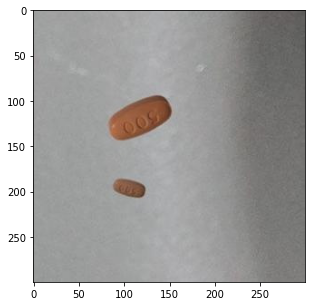

In [4]:
def standardization(image_name):
  image_standardization = io.imread(image_name)
  data = img_to_array(image_standardization)
  samples = expand_dims(image_standardization, 0)
  datagen = ImageDataGenerator(featurewise_center =True,featurewise_std_normalization = True)
  it = datagen.flow(samples, batch_size=1)
  fig, im = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
  image = next(it)[0].astype('uint8')
  im.imshow(image)
standardization('Image_1013.jpg')

## Detail Enhancing Filter

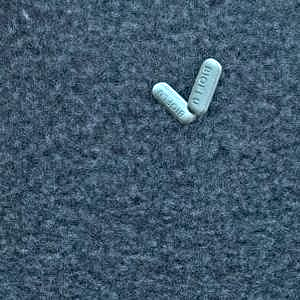

In [ ]:
def detail_enhancing(image_name):
  img = cv2.imread(image_name)
  dst = cv2.detailEnhance(img, sigma_s=10, sigma_r=0.15)
  cv2_imshow(dst)
detail_enhancing('Image_5.jpg')

## Pencil Sketch Filter

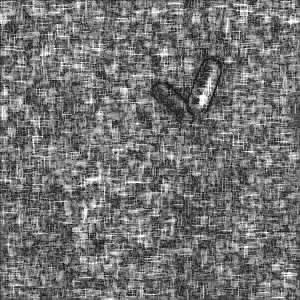

In [ ]:
def pencil_sketch(image_name):
  img=cv2.imread(image_name)
  imout_gray, imout = cv2.pencilSketch(img, sigma_s=60, sigma_r=0.07, shade_factor=0.05)
  cv2_imshow(imout_gray)
pencil_sketch('Image_5.jpg')

## Cartoon Effect

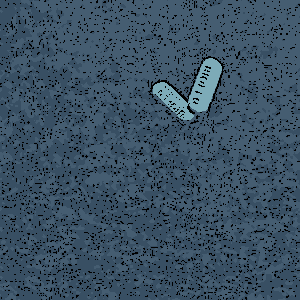

In [ ]:
def cartoon_effect(image_name):
   img=cv2.imread(image_name)
   gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   edges  = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 8)
   data = np.float32(img).reshape((-1, 3))
   criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
   _, label, center = cv2.kmeans(data, 3, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
   center = np.uint8(center)
   result = center[label.flatten()]
   result = result.reshape(img.shape)
   blurred = cv2.medianBlur(result, 3)
   cartoon = cv2.bitwise_and(blurred, blurred, mask=edges)
   cv2_imshow(cartoon)
cartoon_effect('Image_5.jpg')

## Water Color

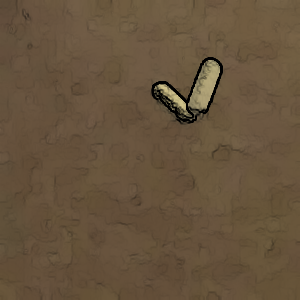

In [ ]:
def water_color(image_name):
  img=cv2.imread(image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_style = cv2.stylization(img, sigma_s=150,sigma_r=0.25)
  cv2_imshow(img_style)
water_color('Image_5.jpg')

## Image Erosion and Dilation

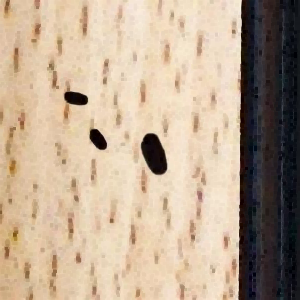

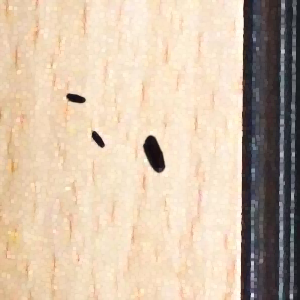

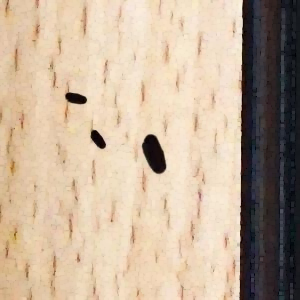

In [10]:
def eroded_dilated(image_name): 
  img = cv2.imread(image_name)
  kernel = np.ones((3, 3), np.uint8)
  img_erosion = cv2.erode(img, kernel, iterations=1)
  img_dilation = cv2.dilate(img, kernel, iterations=1)
  img_eroded_dilated=cv2.dilate(img_erosion,kernel,iterations=1)
  #horizontal_concat = np.concatenate((img_erosion,img_dilation,img_eroded_dilated), axis=1)
  cv2_imshow(img_erosion)
  cv2_imshow(img_dilation)
  cv2_imshow(img_eroded_dilated)
  #cv2_imshow(horizontal_concat)
eroded_dilated('Image_1008.jpg')

## Frequency domain

In [ ]:
def noisy(noise_typ,image):
       if noise_typ == "gauss":
          row,col,ch= image.shape
          mean = 0
          var = 0.1
          sigma = var**0.5
          gauss = np.random.normal(mean,sigma,(row,col,ch))
          gauss = gauss.reshape(row,col,ch)
          noisy = image + gauss
          return noisy
       elif noise_typ == "s&p":
            row,col,ch = image.shape
            s_vs_p = 0.5
            amount = 0.004
            out = np.copy(image)
            # Salt mode
            num_salt = np.ceil(amount * image.size * s_vs_p)
            coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
            out[coords] = 1

            # Pepper mode
            num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
            coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
            out[coords] = 0
            return out
       elif noise_typ == "poisson":
            vals = len(np.unique(image))
            vals = 2 ** np.ceil(np.log2(vals))
            noisy = np.random.poisson(image * vals) / float(vals)
            return noisy
       elif noise_typ =="speckle":
               row,col,ch = image.shape
               gauss = np.random.randn(row,col,ch)
               gauss = gauss.reshape(row,col,ch)        
               noisy = image + image * gauss
               return noisy

<ipython-input-59-55fdc93f5bcd>:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 1
<ipython-input-59-55fdc93f5bcd>:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[coords] = 0


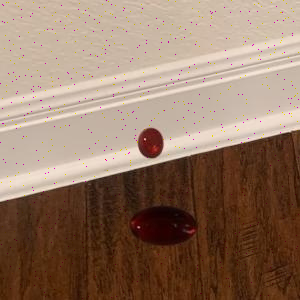

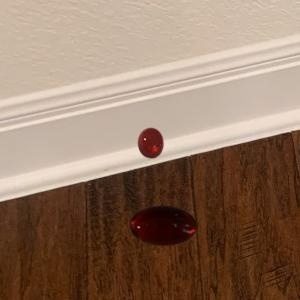

True

In [ ]:
image = cv2.imread('/content/drive/My Drive/pharmaceutical_drug/train/Image_1012.jpg') 
noise_img = noisy('s&p',image)
another_noise_img=noisy('gauss',image)
cv2_imshow(noise_img)
cv2_imshow(another_noise_img)
cv2.imwrite('sp_noise.jpg', noise_img)
cv2.imwrite('gauss_noise.jpg',another_noise_img)

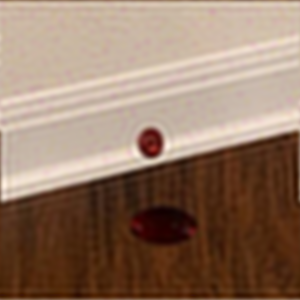

In [ ]:
def lowpass_filter(image_name):
  img = cv2.imread(image_name)
  dft = np.fft.fft2(img, axes=(0,1))
  dft_shift = np.fft.fftshift(dft)
  # generate spectrum from magnitude image (for viewing only)
  mag = np.abs(dft_shift)
  spec = np.log(mag) / 20
  radius = 32
  mask = np.zeros_like(img, dtype=np.float32)
  cy = mask.shape[0] // 2
  cx = mask.shape[1] // 2
  cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
  # blur the mask
  mask2 = cv2.GaussianBlur(mask, (19,19), 0)
  # apply mask to dft_shift
  dft_shift_masked = np.multiply(dft_shift,mask)/255
  dft_shift_masked2 = np.multiply(dft_shift,mask2)/255
  # shift origin from center to upper left corner
  back_ishift = np.fft.ifftshift(dft_shift)
  back_ishift_masked = np.fft.ifftshift(dft_shift_masked)
  back_ishift_masked2 = np.fft.ifftshift(dft_shift_masked2)
  # do idft saving as complex output
  img_back = np.fft.ifft2(back_ishift, axes=(0,1))
  img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))
  img_filtered2 = np.fft.ifft2(back_ishift_masked2, axes=(0,1))
  # combine complex real and imaginary components to form (the magnitude for) the original image again
  img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
  img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)
  img_filtered2 = np.abs(img_filtered2).clip(0,255).astype(np.uint8)
  cv2_imshow(img_filtered2)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
lowpass_filter('sp_noise.jpg')

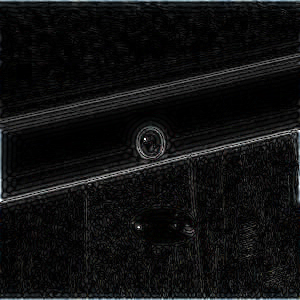

In [ ]:
def highpass_filter(image_name):
  img = cv2.imread(image_name)
  dft = np.fft.fft2(img, axes=(0,1))
  dft_shift = np.fft.fftshift(dft)
  # generate spectrum from magnitude image (for viewing only)
  mag = np.abs(dft_shift)
  spec = np.log(mag) / 20
  # create white circle mask on black background and invert so black circle on white background # as highpass filter
  radius = 32
  mask = np.zeros_like(img, dtype=np.float32)
  cy = mask.shape[0] // 2
  cx = mask.shape[1] // 2
  cv2.circle(mask, (cx,cy), radius, (255,255,255), -1)[0]
  mask=255-mask
  # blur the mask
  mask2 = cv2.GaussianBlur(mask, (19,19), 0)
  # apply mask to dft_shift
  dft_shift_masked = np.multiply(dft_shift,mask)/255
  dft_shift_masked2 = np.multiply(dft_shift,mask2)/255
  # shift origin from center to upper left corner
  back_ishift = np.fft.ifftshift(dft_shift)
  back_ishift_masked = np.fft.ifftshift(dft_shift_masked)
  back_ishift_masked2 = np.fft.ifftshift(dft_shift_masked2)
  # do idft saving as complex output
  img_back = np.fft.ifft2(back_ishift, axes=(0,1))
  img_filtered = np.fft.ifft2(back_ishift_masked, axes=(0,1))
  img_filtered2 = np.fft.ifft2(back_ishift_masked2, axes=(0,1))
  # combine complex real and imaginary components to form (the magnitude for) the original image again
  img_back = np.abs(img_back).clip(0,255).astype(np.uint8)
  img_filtered = np.abs(3*img_filtered).clip(0,255).astype(np.uint8)
  img_filtered2 = np.abs(3*img_filtered2).clip(0,255).astype(np.uint8)
  cv2_imshow(img_filtered2)
  cv2.waitKey(0)
  cv2.destroyAllWindows()
highpass_filter('gauss_noise.jpg')

## Data Preparetion And Modelling

### Build A Base Model

From the eda part, we can see that the training set is small and the best approach to this task will be transfer learning. 

In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.9 MB/s 


## Keras Imagedata generator class

In [6]:
train_datagen = ImageDataGenerator(rescale=1 / 255.0,horizontal_flip=True,validation_split=0.15)
test_datagen = ImageDataGenerator(rescale=1 / 255.0,horizontal_flip=True,)
target_size=300

In [ ]:
start = 0
def plot_loss(history_dict):
      key1 = list(history_dict.keys())[0]
      key2 = list(history_dict.keys())[2]
      loss_values = history_dict[key1][start:]
      val_loss_values=history_dict[key2][start:]
      plt.plot(loss_values,'b-',label=key1)
      plt.plot(val_loss_values,'r--',label=key2)
      plt.title('Training vs Validation Loss')
      plt.legend()
      plt.show()
      print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

def plot_metric(history_dict):
      key1 = list(history_dict.keys())[1]
      key2 = list(history_dict.keys())[3]
      metric_values = history_dict[key1][start:]
      val_metric_values=history_dict[key2][start:]
      plt.plot(metric_values,'b-',label=key1)
      plt.plot(val_metric_values,'r--',label=key2)
      plt.title('Training vs Validation Metric')
      plt.legend()
      plt.show()
      print(key1, ': ', history_dict[key1][-1], key2,': ', history_dict[key2][-1])

In [9]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 6.7 MB/s 


In [25]:
import visualkeras
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D
from PIL import ImageFont

font = ImageFont.truetype('arial.ttf',size=150)
#visualkeras.layered_view(model).show() # display using your system viewer
#visualkeras.layered_view(model, to_file='output.png') # write to disk

visualkeras.layered_view(inception,legend=True,type_ignore=[ZeroPadding2D, Dropout, Flatten],font=font, to_file='output1.png').show() # write and show

In [8]:
xception = keras.applications.Xception(include_top=False,weights="imagenet",input_shape=(target_size,target_size,3),pooling=None,classes=10,classifier_activation="softmax",)

83683744/83683744 [==============================] - 0s 0us/step


In [7]:
vgg = keras.applications.vgg16.VGG16(input_shape=(target_size,target_size,3), weights='imagenet', include_top=False,pooling=None,classes=10,classifier_activation="softmax",)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
resnet=keras.applications.resnet50.ResNet50(include_top=False,weights="imagenet",input_shape=(target_size,target_size,3),pooling=None,classes=10,classifier_activation="softmax")

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
inception=keras.applications.inception_v3.InceptionV3(input_shape=(target_size,target_size,3), weights='imagenet', include_top=False,pooling=None,classes=10,classifier_activation="softmax",)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
def model(model_name,epochs,batch_size,l):
    batch_size = batch_size
    target_size = 300
    train_generator = train_datagen.flow_from_dataframe(dataframe=train,directory=train_image_path,x_col="filename",y_col="label",
                                                    target_size=(target_size, target_size),batch_size=batch_size,class_mode="categorical",
                                                    subset='training',shuffle=True,seed=42)

    valid_generator = train_datagen.flow_from_dataframe(dataframe=train,directory=train_image_path,x_col="filename",y_col="label",
                                                    target_size=(target_size, target_size),batch_size=batch_size,class_mode="categorical",
                                                    subset='validation',shuffle=True,seed=42)
    test_generator = test_datagen.flow_from_dataframe(dataframe=test,directory=test_image_path,x_col="filename",
                                                  target_size=(target_size, target_size),batch_size=1,class_mode=None,shuffle=False,)
    print(train_generator.class_indices)
    class_names = {idx:name for name, idx in train_generator.class_indices.items()}
    print(class_names)
    model = Sequential()
    model.add(model_name)
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adagrad(learning_rate=l), loss='categorical_crossentropy',metrics=['accuracy'])
    tqdm_call = tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)
    #lr_call = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
    #stop_call = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
    history = model.fit(train_generator,validation_data = valid_generator,steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,epochs=epochs, callbacks=[tqdm_call])
    plot_loss(history.history)
    plt.show()
    plot_metric(history.history)
    plt.show()
    path=str(model_name)+".h5"
    model.save(path)

Found 5950 validated image filenames belonging to 10 classes.
Found 1050 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames.
{'Alaxan': 0, 'Bactidol': 1, 'Bioflu': 2, 'Biogesic': 3, 'DayZinc': 4, 'Decolgen': 5, 'Fish Oil': 6, 'Kremil S': 7, 'Medicol': 8, 'Neozep': 9}
{0: 'Alaxan', 1: 'Bactidol', 2: 'Bioflu', 3: 'Biogesic', 4: 'DayZinc', 5: 'Decolgen', 6: 'Fish Oil', 7: 'Kremil S', 8: 'Medicol', 9: 'Neozep'}


Training:   0%|           0/6 ETA: ?s,  ?epochs/s

Epoch 1/6
92/92 [==============================] - 2065s 22s/step - loss: 1.6659 - accuracy: 0.4066 - val_loss: 0.6426 - val_accuracy: 0.7930
Epoch 2/6
92/92 [==============================] - 158s 2s/step - loss: 0.4431 - accuracy: 0.8578 - val_loss: 0.3105 - val_accuracy: 0.9072
Epoch 3/6
92/92 [==============================] - 157s 2s/step - loss: 0.3744 - accuracy: 0.8979 - val_loss: 0.2823 - val_accuracy: 0.9082
Epoch 4/6
92/92 [==============================] - 158s 2s/step - loss: 0.1205 - accuracy: 0.9645 - val_loss: 0.1412 - val_accuracy: 0.9541
Epoch 5/6
92/92 [==============================] - 158s 2s/step - loss: 0.0584 - accuracy: 0.9842 - val_loss: 0.1666 - val_accuracy: 0.9541
Epoch 6/6
92/92 [==============================] - 158s 2s/step - loss: 0.0355 - accuracy: 0.9912 - val_loss: 0.0939 - val_accuracy: 0.9717


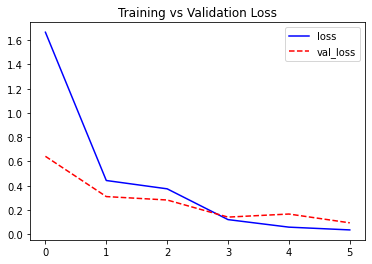

loss :  0.03552792966365814 val_loss :  0.09387758374214172


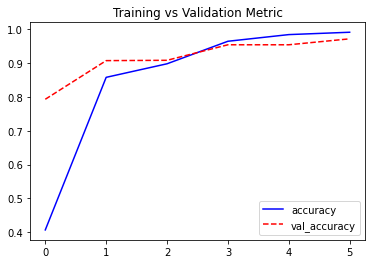

accuracy :  0.9911654591560364 val_accuracy :  0.9716796875


In [ ]:
model(vgg,6,64,0.001) #adagrad

Training:   0%|           0/7 ETA: ?s,  ?epochs/s

Epoch 1/7
185/185 [==============================] - 2113s 11s/step - loss: 0.8209 - accuracy: 0.7847 - val_loss: 0.4948 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/7
185/185 [==============================] - 233s 1s/step - loss: 0.1555 - accuracy: 0.9598 - val_loss: 0.1908 - val_accuracy: 0.9629 - lr: 0.0010
Epoch 3/7
185/185 [==============================] - 230s 1s/step - loss: 0.0912 - accuracy: 0.9784 - val_loss: 0.0771 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 4/7
185/185 [==============================] - 231s 1s/step - loss: 0.0726 - accuracy: 0.9834 - val_loss: 0.1966 - val_accuracy: 0.9365 - lr: 0.0010
Epoch 5/7
185/185 [==============================] - 230s 1s/step - loss: 0.0241 - accuracy: 0.9949 - val_loss: 0.0232 - val_accuracy: 0.9961 - lr: 1.0000e-04
Epoch 6/7
185/185 [==============================] - 231s 1s/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0214 - val_accuracy: 0.9961 - lr: 1.0000e-04
Epoch 7/7
185/185 [==============================] - 230s 1s

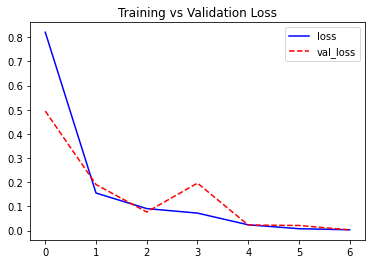

loss :  0.003630339400842786 val_loss :  0.0030140120070427656


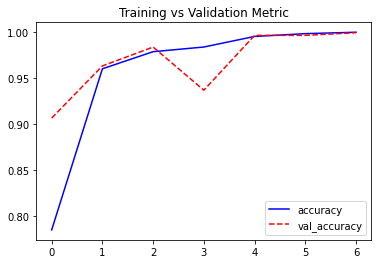

accuracy :  0.9994930624961853 val_accuracy :  0.9990234375


In [ ]:
model(xception,7,32,0.001) 

Found 5950 validated image filenames belonging to 10 classes.
Found 1050 validated image filenames belonging to 10 classes.
Found 3000 validated image filenames.
{'Alaxan': 0, 'Bactidol': 1, 'Bioflu': 2, 'Biogesic': 3, 'DayZinc': 4, 'Decolgen': 5, 'Fish Oil': 6, 'Kremil S': 7, 'Medicol': 8, 'Neozep': 9}
{0: 'Alaxan', 1: 'Bactidol', 2: 'Bioflu', 3: 'Biogesic', 4: 'DayZinc', 5: 'Decolgen', 6: 'Fish Oil', 7: 'Kremil S', 8: 'Medicol', 9: 'Neozep'}


Training:   0%|           0/10 ETA: ?s,  ?epochs/s

Epoch 1/10
  6/185 [..............................] - ETA: 1:17 - loss: 6.0464 - accuracy: 0.1146

185/185 [==============================] - 104s 502ms/step - loss: 0.9819 - accuracy: 0.7888 - val_loss: 0.1454 - val_accuracy: 0.9502
Epoch 2/10
185/185 [==============================] - 86s 463ms/step - loss: 0.0902 - accuracy: 0.9733 - val_loss: 0.0879 - val_accuracy: 0.9678
Epoch 3/10
185/185 [==============================] - 87s 467ms/step - loss: 0.0427 - accuracy: 0.9877 - val_loss: 0.0618 - val_accuracy: 0.9795
Epoch 4/10
185/185 [==============================] - 86s 463ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0533 - val_accuracy: 0.9814
Epoch 5/10
185/185 [==============================] - 86s 463ms/step - loss: 0.0178 - accuracy: 0.9946 - val_loss: 0.0678 - val_accuracy: 0.9766
Epoch 6/10
185/185 [==============================] - 86s 462ms/step - loss: 0.0142 - accuracy: 0.9959 - val_loss: 0.0586 - val_accuracy: 0.9775
Epoch 7/10
185/185 [==============================] - 87s 467ms/step - loss: 0.0166 - accuracy: 0.9959 - val_loss: 0.0519 - val_accuracy: 0.

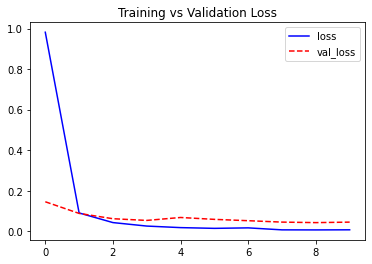

loss :  0.007015989627689123 val_loss :  0.04493675380945206


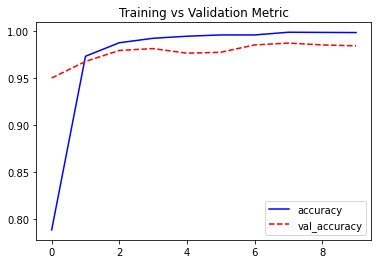

accuracy :  0.9984791874885559 val_accuracy :  0.984375


In [ ]:
model(inception,10,32,0.001)

In [ ]:
def testtime_augmentation(model_name):
  tta_steps = 10
  predictions = []
  for i in tqdm(range(tta_steps)):
           preds = model_name.predict(test_generator, steps = len(test_generator.filenames))
           predictions.append(preds)
           preds = np.mean(predictions, axis=0)
           preds = np.argmax(preds, axis=-1)
           test['label_num']=preds
           display(test.head(2))
           test['label_'+model_name] = test.label_num.map(class_names)
           display(test.head(2))
           path=str(model_name)+".csv"
           test[['filename','label_'+model_name]].to_csv(path, index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

3000/3000 [==============================] - 899s 300ms/step


filename  label_num
0  Image_1.jpg          5
1  Image_2.jpg          4

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 10%|█         | 1/10 [15:00<2:15:04, 900.54s/it]

3000/3000 [==============================] - 33s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 20%|██        | 2/10 [15:34<52:07, 390.94s/it]  

3000/3000 [==============================] - 35s 12ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 30%|███       | 3/10 [16:10<26:41, 228.81s/it]

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 40%|████      | 4/10 [16:45<15:12, 152.10s/it]

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 50%|█████     | 5/10 [17:20<09:09, 109.83s/it]

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 60%|██████    | 6/10 [17:54<05:37, 84.27s/it] 

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 70%|███████   | 7/10 [18:29<03:24, 68.14s/it]

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 80%|████████  | 8/10 [19:04<01:55, 57.54s/it]

3000/3000 [==============================] - 34s 11ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


 90%|█████████ | 9/10 [19:39<00:50, 50.55s/it]

3000/3000 [==============================] - 35s 12ms/step


filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename  label_num     label
0  Image_1.jpg          5  Decolgen
1  Image_2.jpg          4   DayZinc

filename,label
Image_1.jpg,Decolgen
Image_2.jpg,DayZinc
Image_3.jpg,Neozep
Image_4.jpg,Fish Oil
Image_5.jpg,Medicol
Image_6.jpg,Bioflu
Image_7.jpg,Bioflu
Image_8.jpg,Neozep
Image_9.jpg,Decolgen


100%|██████████| 10/10 [20:15<00:00, 121.59s/it]


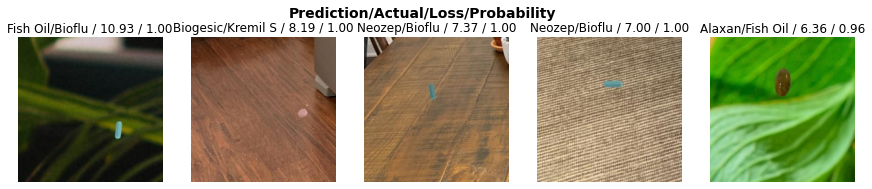

In [ ]:
interp.plot_top_losses(5, nrows = 1)

Looking at the drugs with high losses above, we can see that the pictures are faint compared to the bright pictures from the train batch viewed above. This might be the reason for the bad predictions and can possibily be solved by test time augumentation. Lets verify this below



## Summary

The data was a simple one. There was no need for model ensembling, gradient accumulation, label smoothing, Mixup, or even using dipper architectures. Finding learning rate and training longer (20 epochs) was all I needed.
